## Principal Component Analysis ( PCA )
* Dimensionality Reduction Technique.
* It performs a linear transformation to convert high-dimensionality observations with possibly correlated features into a set of new observations ( Principal Components ) of linearly uncorrelated low-dimension variables.
* High-dimensional data sets, bring the "Curse of dimensionality" and presents computational challenges.
* These Principal Components are orthogonal, which means that are perpendicular to each other and eigenvalues and eigenvectors are used in the approach.
* When dimensions are reduced to a few PC, patterns are identified and outliers are revealed. How?
- - Outliers deviate from the first PC.
- - When projected to low-dimensional hyperplane, tey will fall onto some unique eigenvectors with very small eigenvalues.
* Outlier Score: Sum of weighted distance between each instance to the new hyperplane by the selected eigenvectors.

### Prepare data set

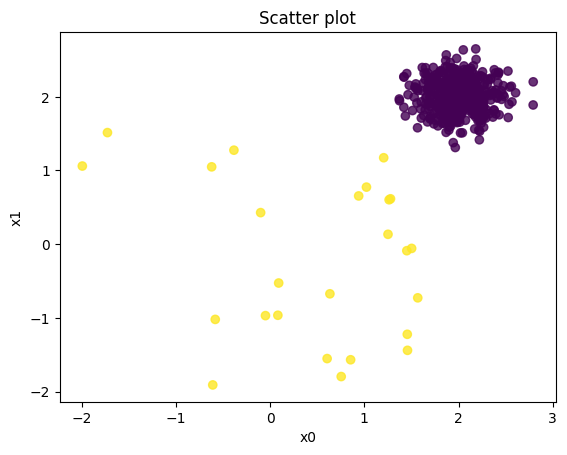

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyod.utils.data import generate_data
from utils_od import count_stat, confusion_matrix, confusion_matrix_threshold,plot_data ,descriptive_stat_threshold 

contamination = 0.05 # percentage of outliers
n_train = 500       # number of training points
n_test = 500        # number of testing points
n_features = 6      # number of features
X_train, X_test, y_train, y_test = generate_data(
    n_train=n_train, 
    n_test=n_test, 
    n_features= n_features, 
    contamination=contamination, 
    random_state=123)

# Make the 2d numpy array a pandas dataframe for each manipulation 
X_train_pd = pd.DataFrame(X_train)
    
# Plot
plt.scatter(X_train_pd[0], X_train_pd[1], c=y_train, alpha=0.8)
plt.title('Scatter plot')
plt.xlabel('x0')
plt.ylabel('x1')
plt.show()

### Build the model
* Dimensionality Reduction Tecnique.
* Eigenvalues will be small for outliers.
* Eigenvectors of the outliers will be distant from normal eigenvectors.

In [2]:
from pyod.models.pca import PCA
pca = PCA(contamination=0.05) 
pca.fit(X_train)

# get the prediction labels and outlier scores of the training data
y_train_pred = pca.labels_  # binary labels (0: inliers, 1: outliers)
y_train_scores = pca.decision_scores_  # .decision_scores_ yields the raw outlier scores for the training data
y_train_scores = pca.decision_function(X_train) # You also can use .decision_function()
y_train_pred = pca.predict(X_train) # You also can use .decision_function()

y_test_scores = pca.decision_function(X_test) # You also can use .decision_function()
y_test_pred = pca.predict(X_test) # You also can use .decision_function()

### Feature Importance ( Explainiability )
* Explained variance Ratio: Explains how much of the total variance is explained by each Principal Component.
* As we can see:
- - First PC explains around 69% of the variance found.
- - Second PC explains around 9.1% of the variance found.


In [7]:
# pca.explained_variance_ without the ratio
print(
    f"Each Principal Component explainability of the variance:\n{pca.explained_variance_ratio_ * 100}")
print()
print(
    f"The sum of the explainiability, sums up to: {round(sum(pca.explained_variance_ratio_),2)}"
)

Each Principal Component explainability of the variance:
[68.81868403  9.17930284  6.43920545  5.77949961  5.17866311  4.60464496]

The sum of the explainiability, sums up to: 1.0


### Determine a reasonable threshold
* The Outlier Score measures the deviation of a data point from others.
* Rank them based on outlier scores.
* Select best threshold ( since we know the % of current outliers = 5% )

In [11]:
print("The threshold for the 5% contamination rate:" , pca.threshold_)

The threshold for the 5% contamination rate: 219.77196222591994


* However, in a real-scenario we don't know the exact %.
* Therefore, we can plot the outlier scores and visually select a threshold:

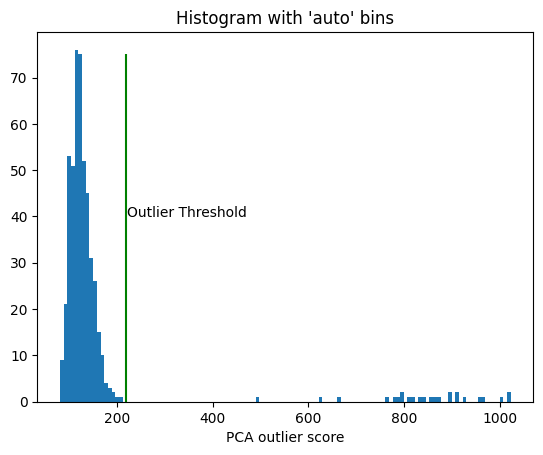

In [24]:
import matplotlib.pyplot as plt
plt.hist(y_train_scores, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram with 'auto' bins")
plt.xlabel('PCA outlier score')
plt.vlines(219, ymin=0, ymax=75, colors="green")
plt.text(x=220, y=40, s="Outlier Threshold")
plt.show()

In [13]:
threshold = pca.threshold_
threshold

def descriptive_stat_threshold(df,pred_score, threshold):
    # Let's see how many '0's and '1's.
    df = pd.DataFrame(df)
    df['Anomaly_Score'] = pred_score
    df['Group'] = np.where(df['Anomaly_Score']< threshold, 'Normal', 'Outlier')

    # Now let's show the summary statistics:
    cnt = df.groupby('Group')['Anomaly_Score'].count().reset_index().rename(columns={'Anomaly_Score':'Count'})
    cnt['Count %'] = (cnt['Count'] / cnt['Count'].sum()) * 100 # The count and count %
    stat = df.groupby('Group').mean().round(2).reset_index() # The avg.
    stat = cnt.merge(stat, left_on='Group',right_on='Group') # Put the count and the avg. together
    return (stat)

descriptive_stat_threshold(X_train,y_train_scores, threshold)

,Group,Count,Count %,0,1,2,3,4,5,Anomaly_Score
0,Normal,475,95.0,2.00,2.01,2.01,1.99,2.01,1.98,124.59
1,Outlier,25,5.0,0.45,-0.21,-0.47,-0.23,-0.03,-0.06,844.33


In [14]:
confusion_matrix_threshold(y_test,y_test_scores,pca.threshold_)

Pred,0,1
Actual,,
0.0,475,0
1.0,0,25


In [33]:
# Put the actual, the HBO score and the ECOD score together
Actual_preds = pd.DataFrame({'Actual': y_test, 
                             'HBO_Score': y_test_hbos_scores, 
                             'ECOD_Score': y_test_ecod_scores, 
                             'PCA_Score': y_test_pca_scores})
Actual_preds['HBOS_pred'] = np.where(Actual_preds['HBO_Score']>hbos.threshold_,1,0)
Actual_preds['ECOD_pred'] = np.where(Actual_preds['ECOD_Score']>ecod.threshold_,1,0)
Actual_preds['PCA_pred'] = np.where(Actual_preds['PCA_Score']>pca.threshold_,1,0)
Actual_preds.head()

,Actual,HBO_Score,ECOD_Score,PCA_Score,HBOS_pred,ECOD_pred,PCA_pred
0,0.0,-0.480781,9.547880,135.864318,0,0,0
1,0.0,-1.118669,9.357850,120.636561,0,0,0
2,0.0,-2.436932,7.993147,105.989093,0,0,0
3,0.0,-0.540879,9.336068,135.381702,0,0,0
4,0.0,-2.092258,8.857059,128.305261,0,0,0


In [26]:
pd.crosstab(Actual_preds['HBOS_pred'],Actual_preds['PCA_pred'])

PCA_pred,0,1
HBOS_pred,,
0,474,0
1,1,25


In [27]:
pd.crosstab(Actual_preds['ECOD_pred'],Actual_preds['PCA_pred'])

PCA_pred,0,1
ECOD_pred,,
0,473,0
1,2,25


## Summary PCA
* Outliers are different from normal data points. When they are projected to the low-dimensional hyperplane, they fall onto the eigenvectors with small eigenvalues. ( Since they explain very little from the data )
* The outlier score of a data point is the sum of the Weighted Euclidean distance between the data point and the low-dimensional hyperplane.